# 연습문제 3 파마 인디언 당뇨

## #01. 패키지 및 그래프

In [1]:
import sys
sys.path.append("../../../")
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터 준비

In [3]:
origin = read_excel("https://data.hossam.kr/F03/pima-indians.xlsx")
print(origin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [4]:
origin.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## #03. 데이터 전처리

### 결측치 확인

In [5]:
origin.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### 명목형 변수 형변환

***명목형 처리(더미변수/카테고리화)***

- `더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

>명목형 확인을 위해서는 데이터의 종류가 몇 가지인지 확인.
즉, 명목형으로 의심되면 일단 value_counts()로 확인.
type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능.

>sigmoid는 이항분류, softmax는 다항분류(one-hot-encoding-즉, 더미변수화)

***종속변수 카테고리의 기준***

>탐색적 데이터 분석에서 사용하기 위해 카테고리화를 진행 - (단, 통계에서는 카테고리 형식으로 데이터를 분석하지 않고 int 형식으로 사용)

>정석대로라면 카테고리로 변경하지 않음. 
단, 탐색적 데이터 분석을 한다면 명목형 변수를 제거해야 하는데 명목형을 카테고리로 변경하면 자동으로 제거해주기 때문에 카테고리 형식으로 변환 후 진행. 

>category 대신 더미변수로 변경하면 int로 돌아오므로 더미변수화를 추천.

In [6]:
origin['Outcome'] = origin['Outcome'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


## #04. 탐색적 데이터 분석

### 기본(기초)통계 확인

In [7]:
origin.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### boxplot

>표준화 결정에 도움

표준화(정규화-scaling)을 진행한도고 해서 모델의 성능차이가 발생하지는 않음.
다만, 시각화를 진행할 때 단위의 차이는 발생.
만약, boxplot을 그렸을 때 데이터의 범주, 단위가 극단적으로 상이할 경우에는 표준화를 진행.

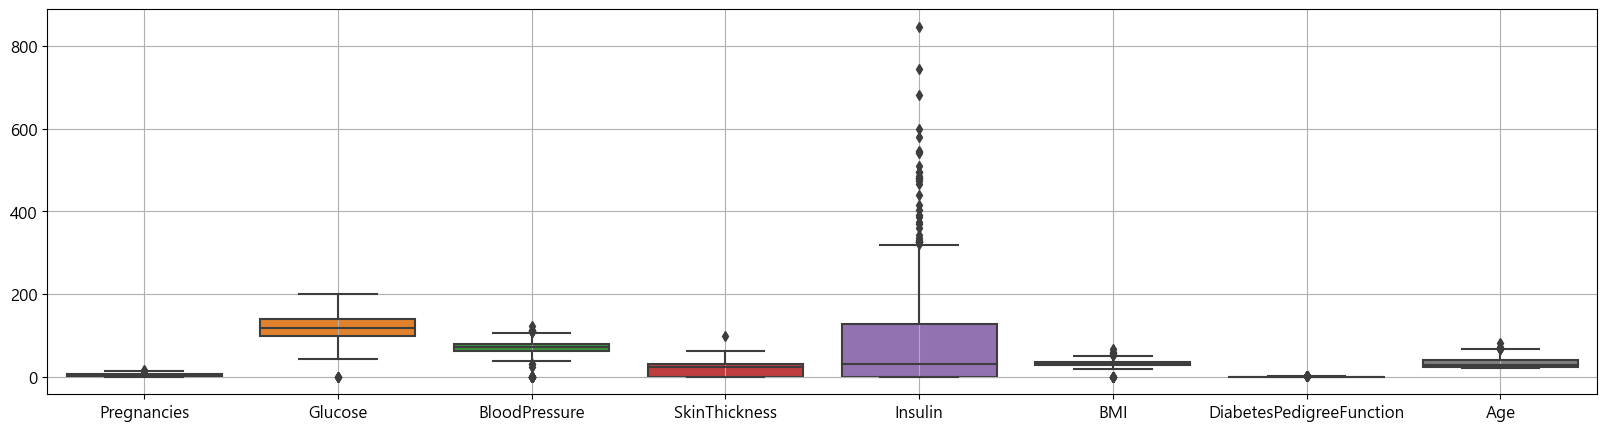

In [8]:
plt.figure(figsize=(20,5))
sb.boxplot(data=origin)
plt.grid()
plt.show()
plt.close()

> 데이터 분포가 서로 상이하므로 표준화가 필요하다고 판단

## #05. 데이터셋 분할

### 랜덤시드 고정

In [9]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [10]:
origin.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [11]:
x = origin.drop('Outcome', axis=1)
y = origin[['Outcome']]
print(x.shape, y.shape)

(768, 8) (768, 1)


In [12]:
print(type(y), type(x))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


### 데이터 표준화

데이터 타입을 numpy, Seris, category, DataFrame으로 할지 명확하게 선정.

In [13]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
x_scale_df = DataFrame(x_scale, columns=x.columns, index=x.index)
x_scale_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


### 훈련 데이터와 검증 데이터로 분할

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scale_df, y, test_size=0.3, random_state=777)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(537, 8) (231, 8) (537, 1) (231, 1)


In [15]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
335,-1.141852,1.380375,0.356432,1.409094,1.521248,2.018958,-0.642912,-0.616111
130,0.046014,1.630752,0.046245,-0.410019,0.765836,-0.290972,-0.334860,-0.020496
255,-0.844885,-0.247076,-0.263941,0.907270,-0.692891,0.204013,0.214802,-1.041549
573,-0.547919,-0.716533,-0.470732,-0.221835,0.349057,0.343624,-0.827139,-0.956462
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023
...,...,...,...,...,...,...,...,...
669,1.530847,1.036107,0.459827,0.593630,0.175399,-0.138669,-0.929823,1.000557
71,0.342981,0.566649,-0.263941,0.907270,0.522715,-0.430583,-0.183854,-0.616111
599,-0.844885,-0.372265,-1.608083,-0.159107,0.349057,-1.128639,-0.195934,-0.616111
571,-0.547919,0.284975,1.390387,-1.288212,-0.692891,-1.192099,-0.615731,-1.041549


## #06. 모델 개발

### 모델 정의

>sigmoid는 이항분류, softmax는 다항분류(원핫인코딩-즉, 더미변수화)

> relu, sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense(출력 수) 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [16]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(x_train.columns), )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [17]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


17/17 [==============================] - 1s 16ms/step - loss: 0.6401 - acc: 0.6741 - val_loss: 0.6116 - val_acc: 0.7013 - lr: 0.0010
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 0.5948 - acc: 0.7132 - val_loss: 0.5750 - val_acc: 0.7532 - lr: 0.0010
Epoch 3/500
17/17 [==============================] - 0s 4ms/step - loss: 0.5654 - acc: 0.7393 - val_loss: 0.5479 - val_acc: 0.7576 - lr: 0.0010
Epoch 4/500
17/17 [==============================] - 0s 4ms/step - loss: 0.5433 - acc: 0.7430 - val_loss: 0.5283 - val_acc: 0.7619 - lr: 0.0010
Epoch 5/500
17/17 [==============================] - 0s 4ms/step - loss: 0.5262 - acc: 0.7430 - val_loss: 0.5127 - val_acc: 0.7706 - lr: 0.0010
Epoch 6/500
17/17 [==============================] - 0s 4ms/step - loss: 0.5129 - acc: 0.7523 - val_loss: 0.5008 - val_acc: 0.7792 - lr: 0.0010
Epoch 7/500
17/17 [==============================] - 0s 4ms/step - loss: 0.5022 - acc: 0.7579 - val_loss: 0.4924 - val_acc: 0.7749 - lr: 0.0010
Epo

## #07. 학습 결과 평가

08-다중선형회귀(데이터프레임화, 손실률 시각화) 참고

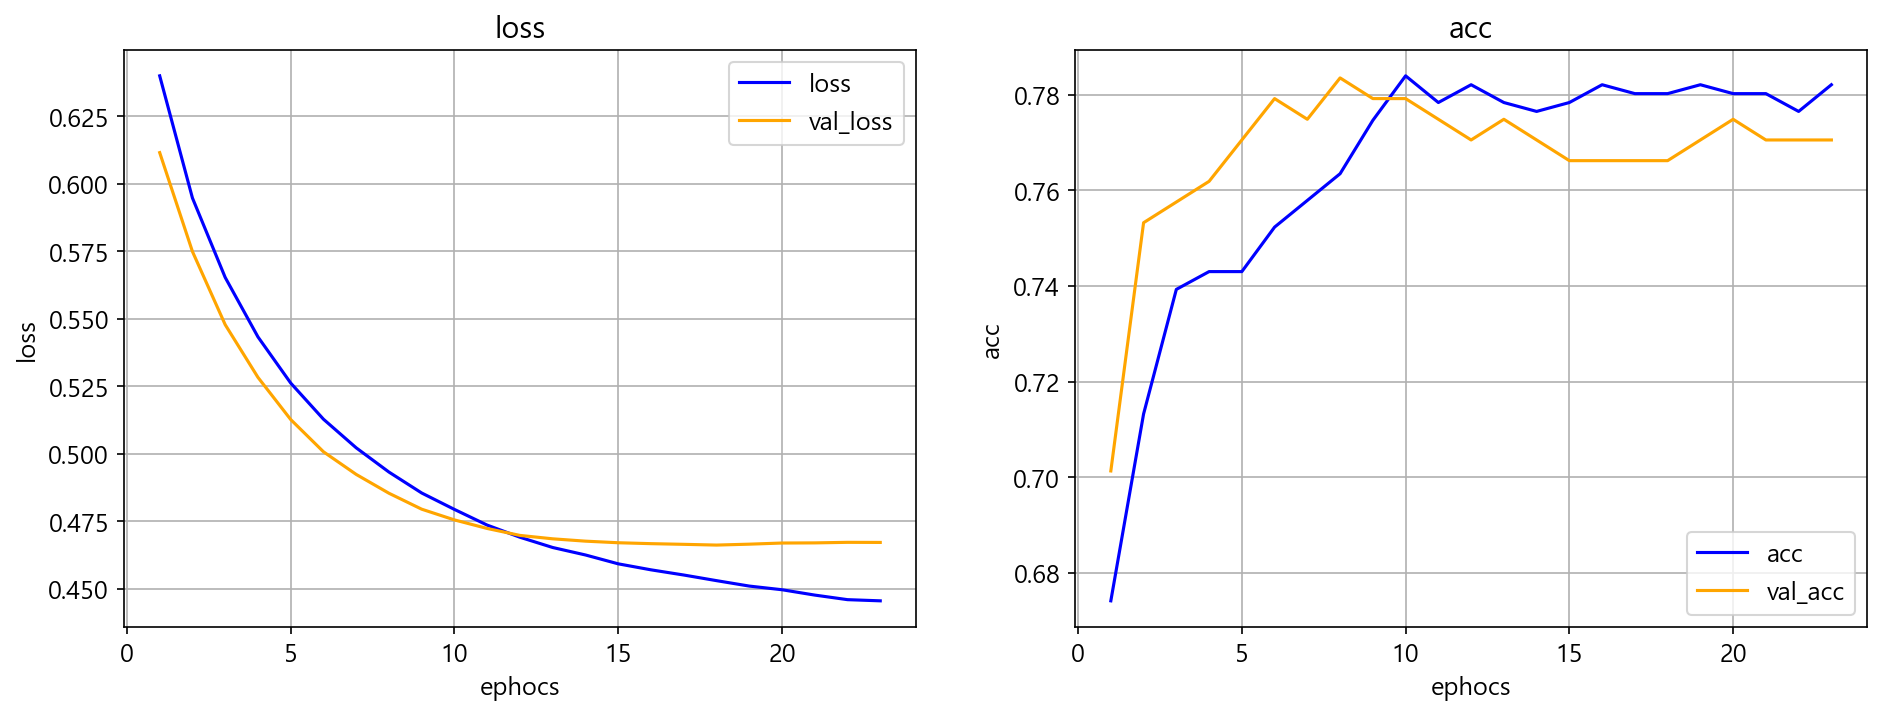

17/17 [==============================] - 0s 1ms/step - loss: 0.4439 - acc: 0.7784
최종 훈련 손실률: 0.443949, 최종 훈련 정확도: 0.778399
8/8 [==============================] - 0s 2ms/step - loss: 0.4672 - acc: 0.7706
최종 검증 손실률: 0.467196, 최종 검증 정확도: 0.770563


In [18]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

0, 1로 나눔.

In [19]:
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print("%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(train_pred)

17/17 [==============================] - 0s 2ms/step
537개의 훈련 데이터가 1개의 경우의 수를 갖는다.
[[0.79993   ]
 [0.7450192 ]
 [0.12339792]
 [0.07611575]
 [0.27248374]
 [0.05400782]
 [0.2924738 ]
 [0.37167925]
 [0.5619099 ]
 [0.26118824]
 [0.4115717 ]
 [0.23009625]
 [0.39074644]
 [0.00654965]
 [0.720679  ]
 [0.45957804]
 [0.08670009]
 [0.57762754]
 [0.05548144]
 [0.08119004]
 [0.08941837]
 [0.16941018]
 [0.35562614]
 [0.24051991]
 [0.15059498]
 [0.09636243]
 [0.28264245]
 [0.02655995]
 [0.45941132]
 [0.04647697]
 [0.2313207 ]
 [0.09543099]
 [0.1608334 ]
 [0.49250776]
 [0.86178565]
 [0.6078528 ]
 [0.02943694]
 [0.27984405]
 [0.57715535]
 [0.19901723]
 [0.2919423 ]
 [0.06900308]
 [0.03137783]
 [0.27959475]
 [0.0333955 ]
 [0.60750544]
 [0.65575284]
 [0.69317436]
 [0.10785104]
 [0.48493555]
 [0.05103735]
 [0.05088375]
 [0.21929757]
 [0.6146241 ]
 [0.17305747]
 [0.81619215]
 [0.13321507]
 [0.7249742 ]
 [0.34134972]
 [0.31030235]
 [0.06713288]
 [0.85177106]
 [0.13756493]
 [0.73172456]
 [0.11102757]
 [0.519

In [29]:
y_train['Outcome'].shape

(537,)

In [28]:
np.round(train_pred.flatten()).shape

(537,)

In [30]:
y_train

,Outcome
335,0
130,1
255,1
573,0
764,0
...,...
669,0
71,0
599,0
571,0


In [31]:
len(y_train['Outcome'])

537

In [33]:
len(np.round(train_pred.flatten()))

537

In [20]:
train_df = DataFrame({
    '관측치': y_train['Outcome'],
    '예측치': np.round(train_pred.flatten())
})

train_df

,관측치,예측치
335,0,1.0
130,1,1.0
255,1,0.0
573,0,0.0
764,0,0.0
...,...,...
669,0,1.0
71,0,0.0
599,0,0.0
571,0,0.0


### 검증 데이터에 대한 예측 결과 산정

In [21]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(test_pred)

8/8 [==============================] - 0s 2ms/step


231개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[0.39627033]
 [0.9132599 ]
 [0.85008377]
 [0.12745129]
 [0.28177145]
 [0.63344437]
 [0.55966425]
 [0.10907085]
 [0.95291907]
 [0.21112315]
 [0.07157377]
 [0.1642893 ]
 [0.03482231]
 [0.10338599]
 [0.4066633 ]
 [0.07310538]
 [0.07080285]
 [0.3868507 ]
 [0.7595439 ]
 [0.12058075]
 [0.05043985]
 [0.3496894 ]
 [0.8657955 ]
 [0.7862284 ]
 [0.15512642]
 [0.17740126]
 [0.06780022]
 [0.63619334]
 [0.06897256]
 [0.5688019 ]
 [0.10684501]
 [0.08742724]
 [0.1993608 ]
 [0.04900552]
 [0.24977589]
 [0.02863042]
 [0.18811563]
 [0.18293501]
 [0.64556897]
 [0.01257597]
 [0.1208931 ]
 [0.26627436]
 [0.08646017]
 [0.8771322 ]
 [0.68400043]
 [0.01278983]
 [0.16235961]
 [0.1982209 ]
 [0.0430111 ]
 [0.1292298 ]
 [0.68050635]
 [0.0884143 ]
 [0.04986588]
 [0.38701326]
 [0.2846307 ]
 [0.13854821]
 [0.05714026]
 [0.90401095]
 [0.591156  ]
 [0.7326304 ]
 [0.36495137]
 [0.8638446 ]
 [0.8590043 ]
 [0.6889584 ]
 [0.42856687]
 [0.07632713]
 [0.04610252]
 [0.11787992]
 [0.00103934]
 [0.

### 결과 데이터 셋 구성

In [22]:
test_df = DataFrame({
    '관측치': y_test['Outcome'],
    '예측치': np.round(test_pred.flatten())
})

test_df

,관측치,예측치
387,1,0.0
43,1,1.0
408,1,1.0
262,0,0.0
533,0,0.0
...,...,...
46,0,1.0
290,0,0.0
418,0,0.0
434,0,0.0


### 결과 확인

In [23]:
logit = helper.tf_logit_result(model, result, x_train, y_train)
logit

17/17 [==============================] - 0s 2ms/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
logit.cmdf

,Negative,Positive
True,296,74
False,45,122


In [25]:
logit.result_df.T

,0
정확도(Accuracy),0.778399
정밀도(Precision),0.730539
"재현율(Recall, TPR)",0.622449
"위양성율(Fallout, FPR)",0.131965
"특이성(Specificity, TNR)",0.868035
RAS,0.745242
f1_score,0.672176


In [26]:
logit.odds_rate_df

array([1.5151168], dtype=float32)